# Introducing composite functions with Quantum Monte Carlo Integration

In this tutorial we introduce how to write custom quantum functions with Classiq, and subsequently use them for more complex functions/algorithms. This will be illustrated on a specific use-case of Quantum Monte Carlo Integration (QMCI). The example below demonstrates how we can exploit various concepts of modeling quantum algorithms with Classiq--- **inverse-logic**, **qreg slicing**, **qreg concatenation**, and **skip-control** --- when building our own  functions.

## QMCI

We start with a brief introduction to the quantum algorithm treated in this tutorial.

Monte Carlo integration refers to estimating expectation values of a function $f(x)$, where $x$ is a random variable drawn from some known distribution $p$:

\begin{equation}
\tag{1}
E_{p}(x) = \int f(x)p(x) dx.
\end{equation}
Such evaluations appear in the context of option-pricing or credit risk-analysis.

The basic idea of QMCI assumes that we have a quantum function $A$, which, for a given $f$ and $p$, loads the following state of $n+1$ qubits:
\begin{align}
\tag{2}
A|0\rangle_n|0\rangle = \sum^{2^n-1}_{i=0} \sqrt{f_i} \sqrt{p_i}|i\rangle_n|1\rangle + \sum^{2^n-1}_{i=0} \sqrt{1-f_i} \sqrt{p_i}|i\rangle_n|0\rangle = \sqrt{a}|\psi_1\rangle+\sqrt{1-a^2}|\psi_0\rangle,
\end{align}
where it is understood that the first $2^n$ states represent a discretized space of $x$, and that $0\leq f(x)\leq 1$.
Then, by applying Amplitude Estimation (AE) algorithm for the "good-state" $|\psi_1 \rangle$, we can estimate its amplitude
$$
a = \sum^{2^n-1}_{i=0} f_i p_i.
$$

The QMCI algorithm can be separated into two parts:
1) Constructing a Grover operator for the specific problem--- this will be done here almost from scratch, using user-defined functions in Classiq.
2) Applying AE algorithm based on the Grover operator [[1](#AE)]--- this will be done by calling Classiq's Quantum Phase Estimation (QPE) function.

### Specific use-case for the tutorial

For simplicity we will consider a simple use-case. We take a probability distribution on the integers
$$
\tag{3}
p_i = \frac{i}{\mathcal{N}} \text{ for } i\in \{0,\dots 2^3-1\},
$$
where $\mathcal{N}$ is a normalization constant, and we would like to evaluate the expectation value of the function
$$
\tag{4}
f(x) = \sin^2(0.25x+0.2).
$$
Therefore, the value we want to evaluate is:
$$
a= \frac{1}{\mathcal{N}} \sum^7_{k=0} \sin^2(0.25k+0.2) k \approx 0.834.
$$

## 1. Building the corresponding Grover Operator with Composite Functions

### Composite Functions

Composite functions are user-defined functions built with other quantum functions. Composite functions are defined very similar to a Model, containing a logic flow, inputs, and outputs. The typical workflow is:
1. Defining a `CompositeFunctionGenerator` object.
2. Setting inputs.
3. Defining logic flow.
4. Defining outputs.
5. Adding the function to the function library, so it can be used within a model, or another Composite function.

We can start with importing the relevant objects, and defining a function library `qmci_library`

In [1]:
from classiq import FunctionGenerator, FunctionLibrary

qmci_library = FunctionLibrary()

### Grover operator for QMCI

The Grover operator suitable for QMCI is defined as follows:
$$
Q\equiv - S_{\psi_1} A^{\dagger} S_0 A,
$$
with $S_0$ and $S_{\psi_1}$ being reflection operators around the zero state $|0\rangle_n|0\rangle$ and the good-state $|\psi_1\rangle$, respectively, and the function $A$ is defined in Eq. ([2](#mjx-eqn-2)).

In subsections (1.1)-(1.3) below we build each of the quantum sub-functions, and then in subsection (1.4) we wire them to define a complete Grover operator. On the way we introduce several concepts of functional modeling, such as inverse, or skip-control, which allow Classiq's Synthesis Engine to reach better optimized circuits. Some specific concepts are indicated at the header of each subsection.

#### 1.1) The state loading $A$ function

We start with constructing the $A$ operator in Eq. ([2](#mjx-eqn-2)). We define a composite function and give it the name `state_loading`

In [2]:
function_generator = FunctionGenerator(function_name="state_loading")

The function's inputs and outputs is comprised of two registers: a quantum register `io` of size $n=3$ for the discretization of space, and an `ind` register of size 1 to indicate the good state. First, we define the input:

In [3]:
from classiq import QUInt

sp_num_qubits = 3
input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

Next, we model the logic flow of our function. As can be seen from Eq. ([2](#mjx-eqn-2)), the state loading can be constructed with Classiq's StatePreparation [[SP](#SP)] on $n=3$ qubits with probabilities $p_i$ followed by Classiq's LinearPauliRotation [[LPR](#LPR)]. Let us import these built-in functions, and define their parameters according to our specific problem described by Eqs. ([3](#mjx-eqn-3)-[4](#mjx-eqn-4))

In [4]:
import numpy as np

from classiq.builtin_functions import LinearPauliRotations, StatePreparation

probabilities = np.linspace(0, 1, 2**sp_num_qubits) / sum(
    np.linspace(0, 1, 2**sp_num_qubits)
)
sp_params = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.00}}
)

linear_pauli_rotations_params = LinearPauliRotations(
    num_state_qubits=sp_num_qubits, bases="Y", offsets=0.4, slopes=0.5
)

Now, we can wire the inner function calls and set the outputs. For the StatePreparation block we toggle the `strict_zero_ios` flag; a full explanation of this parameter is given at the end of this subsection.

In [5]:
sp_output = function_generator.StatePreparation(
    params=sp_params, strict_zero_ios=False, in_wires=input_dict["io"]
)

lpr_out = function_generator.LinearPauliRotations(
    params=linear_pauli_rotations_params,
    in_wires={"state": sp_output["OUT"], "target": input_dict["ind"]},
)

function_generator.set_outputs({"io": lpr_out["state"], "ind": lpr_out["target"]})

Finally, we add the `state_loading` function to our library

In [6]:
qmci_library.add_function(function_generator.to_function_definition())

##### The `strict_zero_ios` flag:
Some of our built-in functions assume a zero input, and thus by default cannot be called with `in_wires`. One example is the StatePreparation function, which prepares a state of with given probabilities, *under the assumption that we start at a zero state*. To allow in-wiring for such function we toggle the `strict_zero_ios` flag. This also means that the function has an out-wiring when we call its inverse.

We can examine the function we built by defining a Model which calls it.

In [7]:
from classiq import Model, show, synthesize

model = Model()
model.include_library(qmci_library)
model.state_loading()

qprog = synthesize(model.get_model())
show(qprog)

Opening: https://platform.classiq.io/circuit/f68240ac-5c27-4365-953c-262ff27f88b7?version=0.34.0.dev0%2B124706fb0e


#### 1.2) $S_{\psi_1}$ function

The next quantum function we build is the one which reflects around the good state: any $n+1$ state in which the `ind` register is at state $|1\rangle$. This function can be simply constructed with a ZGate on the `ind` register. Note that we shall still define $n+1$ (`io` and `ind`) inputs and outputs registers for the function. Let us define the function, giving it a name `good_state_oracle`, in one code block:

In [8]:
from classiq.builtin_functions import ZGate

function_generator = FunctionGenerator(function_name="good_state_oracle")

input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

z_out = function_generator.ZGate(
    params=ZGate(),
    in_wires={"TARGET": input_dict["ind"]},
)

function_generator.set_outputs({"ind": z_out["TARGET"], "io": input_dict["io"]})

We end with adding the function into our library

In [9]:
qmci_library.add_function(function_generator.to_function_definition())

#### 1.3) $S_{0}$ function (and introducing qreg slicing/concatenation and `should_control` flag)

The $S_{0}$ function resembles the $S_{\psi_1}$ operation, inverting an $n+1$-sized Hilbert space around the zero state $|0\rangle_{n+1}$. Note that this function is a generic one, independent of the specific problem and partitioning to `io` and `ind` registers. We thus define a generic `zero_oracle` function, having $n+1$-sized input and output registers, which we designate with the name `mcz_io`.

In [10]:
function_generator = FunctionGenerator(function_name="zero_oracle")

reg_size = sp_num_qubits + 1
input_dict = function_generator.create_inputs({"mcz_io": QUInt[reg_size]})

Consider a general state of $n+1$ qubits, $|\psi\rangle=|q_0q_1,\dots q_n\rangle$. We choose an arbitrary qubit, say the first one. We would like to apply a (-Z)Gate on it, controlled by all the rest of the $n$ qubits being at state zero (e.g., open control).  One can verify that:
\begin{eqnarray}
|00\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} -|00\dots0\rangle, \\
|10\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |10\dots0\rangle, \\
|11\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |11\dots0\rangle,\\
|11\dots1\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |11\dots1\rangle,
\end{eqnarray}
which is exactly the functionality we want.

The way we construct the above logic is by calling the relevant MCZ gate, sandwiching the selected target qubit with an XGate (this is equivalent to an MC(-Z) gate). For applying an XGate on $q_0$ we employ register slicing:

In [11]:
from classiq.builtin_functions import XGate

x_out = function_generator.XGate(
    params=XGate(),
    in_wires={"TARGET": input_dict["mcz_io"][0]},
    should_control=False,
)

The `should_control` flag will be explained at the end of this subsection.

Next, we define the properties of the controlled operation, controlling over the state of $n$ qubits at state zero.

In [12]:
from classiq import ControlState

control_states = ControlState(ctrl_state="0" * (reg_size - 1), name="ctrl_reg")

where we also provide a name for the controlled register, `ctrl_reg`. Now we call the Controlled-ZGate

In [13]:
mcz_out = function_generator.ZGate(
    params=ZGate(),
    control_states=control_states,
    in_wires={"TARGET": x_out["TARGET"], "ctrl_reg": input_dict["mcz_io"][1:reg_size]},
)

Finally, we apply the XGate on the target qubit, define the output, and add the function to the library. For the output we need to concatenate the out-wires of the MCZ gate and the XGate.

In [14]:
from classiq import QReg

x_out = function_generator.XGate(
    params=XGate(), in_wires={"TARGET": mcz_out["TARGET"]}, should_control=False
)

function_generator.set_outputs(
    {"mcz_io": QReg.concat(x_out["TARGET"], mcz_out["ctrl_reg"])}
)

qmci_library.add_function(function_generator.to_function_definition())

#### `should_control` parameter

If we have a quantum function of the form $UVU^{\dagger}$, then when controlling over it we can avoid controlling over the first and last operations: $ctrl(UVU^{\dagger})$ is equivalent to $Uctrl(V)U^{\dagger}$. By passing `should_control=False`, the engine knows to skip controlling over this function. Note that in Section (2), when we apply AE on our Grover operator, we indeed call a control operation on $S_0$. Therefore, the `should_control` flag is essential for recieving an optimal quantum circuit for our use-case.

#### 1.4) $Q$ function (and introducing `inverse`  logic)

We can now define a complete Grover operator $Q\equiv -S_{\psi_1} A^{\dagger} S_0 A$. We will do this in a single code block. We emphasize several points:
1. The operation of $A^{\dagger}$ is done by calling $A$ and raising the flag `is_inverse=True`.
2. We pass `should_control=False` for $A$ and $A^{\dagger}$.
3. When wiring from $ A^{\dagger}$ to  $S_0$ we use concatenation of the $n$-sized (`io`) and single-sized (`ind`) registers into the $(n+1)$-sized `mcz_io` register.
4. When wiring from $S_0$ to $A$ we use the corresponding opposite call of register slicing, from `mcz_io` to `io` and `ind`.
5. We add a global phase of -1 to the full operator, by using the built-in `UGate`.

In [15]:
from classiq.builtin_functions import UGate

## composite for Grover Diffuser

function_generator = FunctionGenerator(function_name="grover")
function_generator.include_library(qmci_library)


in_wires = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

oracle_out = function_generator.good_state_oracle(in_wires=in_wires)

sps_inverse_out = function_generator.state_loading(
    in_wires={"io": oracle_out["io"], "ind": oracle_out["ind"]},
    is_inverse=True,
    should_control=False,
)

zero_oracle_out = function_generator.zero_oracle(
    in_wires={"mcz_io": QReg.concat(sps_inverse_out["io"], sps_inverse_out["ind"])}
)


sps_out = function_generator.state_loading(
    in_wires={
        "io": zero_oracle_out["mcz_io"][0:sp_num_qubits],
        "ind": zero_oracle_out["mcz_io"][sp_num_qubits],
    },
    should_control=False,
)


global_phase_out = function_generator.UGate(
    UGate(theta=0, phi=0, lam=0, gam=np.pi), in_wires={"TARGET": sps_out["ind"]}
)


function_generator.set_outputs({"io": sps_out["io"], "ind": global_phase_out["TARGET"]})


qmci_library.add_function(function_generator.to_function_definition())

##### Let us look at the `grover` function we created

In [16]:
from classiq import Model, show, synthesize

model = Model()
model.include_library(qmci_library)
model.grover()

qprog = synthesize(model.get_model())
show(qprog)

Opening: https://platform.classiq.io/circuit/a153d910-b5ae-4492-a167-72c9923d8835?version=0.34.0.dev0%2B124706fb0e


## 2. Applying Amplitude Estimation (AE) with Quantum Phase Estimation (QPE)

Below we apply a basic AE algorithm which is based on QPE. The idea behind this Algorithm is the following:

The state $A|0\rangle_n|0\rangle$ is spanned by two eigenvectors of our Grover operator $Q$, with the two corresponding eigenvalues
\begin{equation}
\tag{5}
\lambda_{\pm}=\exp\left(\pm i2\pi \theta \right), \qquad \sin^2 \left(\pi \theta\right)\equiv a.
\end{equation}
Therefore, if we apply a QPE on $A|0\rangle_n|0\rangle$ we will have these two eigenvalues encoded in the QPE register, however, both give the value of $a$, so there is no ambiguity here.

To find $a$ we are going to build a simple quantum model: we apply $A$ on a quantum register of size $n+1$ initialized to zero, and then apply Classiq's QPE [[QPE](#QPE)] with our user-defined Grover operator.

Below, we build our model, define its output, and synthesize it. In particular, we define the output `phase_result` which holds the phase register of the QPE. We choose a QPE with phase register of size 3, governing the accuracy of our Phase-, and thus Amplitude-, Estimation. The way to pass our user defined function to the QPE is through the `unitary` and `unitary_params` parameters as follows:

In [17]:
from classiq import Model
from classiq.builtin_functions import PhaseEstimation
from classiq.model import Constraints

n_qpe = 3
model = Model(constraints=Constraints(max_width=9))
model.include_library(qmci_library)
sp_output = model.state_loading()

qpe_out = model.PhaseEstimation(
    params=PhaseEstimation(
        size=n_qpe, unitary_params=qmci_library.get_function("grover"), unitary="grover"
    ),
    in_wires={"io": sp_output["io"], "ind": sp_output["ind"]},
)

model.set_outputs({"phase_result": qpe_out["PHASE_ESTIMATION"]})

In [18]:
from classiq import show, synthesize

model.sample()
qmod = model.get_model()

In [19]:
with open("qmc_user_defined.qmod", "w") as f:
    f.write(qmod)

In [20]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/4144303e-6eda-4c69-ae65-3136f70d11bc?version=0.34.0.dev0%2B124706fb0e


### Finally, we execute the circuit and measure the approximated amplitude

We start with a simple execution on a simulator

In [21]:
import matplotlib.pyplot as plt

from classiq import execute

results = execute(qprog).result()

In [22]:
from classiq.execution import ExecutionDetails

res = results[0].value

The counts for the phases stored in the `phase_result` are given in `res.parsed_counts`

In [23]:
phases_counts = res.parsed_counts

We identify $|\lambda_0,\lambda_1\dots \lambda_{m-1}\rangle_m=\frac{1}{2^m}\sum^{m-1}_{i=0}\lambda_i 2^i$, whose mapping can be done as follows:

In [24]:
## mapping between register string to phases
phases_counts = dict(
    (sampled_state.state["phase_result"] / 2**n_qpe, sampled_state.shots)
    for sampled_state in res.parsed_counts
)

Plotting the resulting histogram we see two phase values with high probability (however, both corresponds to the same amplitude $a$)

phase with max probability:  0.625


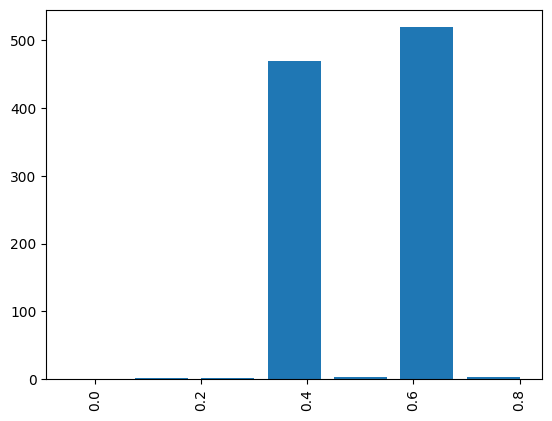

In [25]:
plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

Recall the relation in Eq. ([5](#mjx-eqn-5)), we can read the amplitude $a$ from the phase with max probability, and compare to the expected amplitude:

In [26]:
print(
    "measured amplitude: ",
    np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2,
)
print(
    "exact amplitude: ",
    sum(np.sin(0.5 * n / 2 + 0.4 / 2) ** 2 * probabilities[n] for n in range(2**3)),
)

measured amplitude:  0.8535533905932737
exact amplitude:  0.8338393824876795


## References

<a name='AE'>[1]</a>: [Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2002). Quantum Amplitude Amplification and Estimation. Contemporary Mathematics, 305, 53-74.](https://arxiv.org/abs/quant-ph/0005055)

<a name='SP'>[SP]</a>: [Classiq's StatePreparation built-in function](https://docs.classiq.io/latest/user-guide/builtin-functions/state-preparation/state-preparation/)

<a name='LPR'>[LPR]</a>: [Classiq's LinearPauliRotations built-in function](https://docs.classiq.io/latest/user-guide/builtin-functions/linear-pauli-rotations/)

<a name='QPE'>[QPE]</a>: [Classiq's QuantumPhaseEstimation built-in function](https://docs.classiq.io/latest/user-guide/builtin-functions/qpe/)
